*Christoffer Riis [chrrii@dtu.dk], DTU Management*

# Advanced Business Analytics

## Lecture 10 - Ensemble models: XGBoost

Welcome to this weeks notebook. This time we will look at the technique of *ensembling*. More precisely, we will first look at the ensemble model XGBoost and then investigate the concept of an ensemble of models. So you see that we will look at ensembling on two different scales which can easily be combined to make an ensemble of ensembles.

You work for a Data Sciences consulting company and got a new contract with an influencing company that wants to know what makes an Instagram post popular so that they can increase their engagement. To start simple, you will only consider information from the author of the post, metadata about the post and temporal information regarding the post.

Your goal is to predict the number of likes (a proxy for engagement) a post will get and then try to explain which components are relevant to get a high engagement.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from math import sqrt

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# To measure the training time
from time import time

import matplotlib.pyplot as plt

You are given a data set that contains data about approximate 52k Instagram posts posted around November and December in 2019. Before we describe the data, let us first load it. 

In [2]:
dataset = pd.read_pickle("instagram_data.pkl")

In [3]:
# if you exceed the recursion limit, try to increase the limit by import sys; sys.setrecursionlimit(3500)
dataset.head(5)

,logFollowers,logFollowing,logPosts,followersStatusRatio,followersFriendsRatio,filter,lang,tagCount,usersTagged,userHasLiked,postedHour,postedDate,postedWeekDay,logLikes,logComments
0,-1.868796,-1.658002,0.698091,0.156228,1.793388,26,24,23,0,0,23,32,1,1.074190,-0.590773
1,-0.284441,-1.456580,-0.465204,2.447005,7.175676,32,9,17,0,0,22,32,1,0.320418,-0.590773
2,1.099499,-0.364747,0.310818,4.497349,9.616780,26,9,28,6,0,14,32,1,3.269233,-0.590773
3,-0.498687,0.685075,0.153836,1.063275,0.680159,26,9,27,0,0,16,32,1,0.971006,-0.590773
4,0.539883,-0.956624,1.029098,1.252844,9.930328,26,24,4,0,0,1,29,5,1.499073,1.894133


You see there are 15 features in total: 13 predictive features and two targets (likes and comments). We can divide the predictive features into three categories: author, content and temporal features.

The features we will use are:
* Author features:
    - logFollowers: the log number of followers the user has
    - logFollowing: the log number of users the user is following
    - logPosts: the log number of posts the user has made
    - followersStatusRatio: the number of followers per post
    - followersFriendsRatio: the number of followers per "following"
* Content features:
    - filter: type of filter applied to the images
    - lang: language of the post
    - tagCount: the number of hashtags
    - usersTagged: the number of users tagged
    - userHasLiked: has the user liked their post
* Temporal features:
    - postedHour: the posted hour
    - postedDate: posted date of the month
    - postedWeekDay: posted day of the week

In [4]:
# Initialize list of features and categorical features. You can specify the feature groups
# you will use in the following variable
feature_groups = ['author', 'content', 'temporal']

# initialize list with features
features = []
cat_features = []

# get the name of features to use
if 'author' in feature_groups:
    features += ['logFollowers', 'logFollowing', 'logPosts', 'followersStatusRatio', 'followersFriendsRatio']
if 'content' in feature_groups:
    features += ['filter', 'lang', 'tagCount', 'usersTagged', 'userHasLiked']
    cat_features += ['filter', 'lang']
if 'temporal' in feature_groups:
    features += ['postedHour', 'postedDate', 'postedWeekDay']
    cat_features += ['postedDate', 'postedWeekDay']
    
print("Features in use:\n", features)
print("Categorical features:\n", cat_features)

Features in use:
 ['logFollowers', 'logFollowing', 'logPosts', 'followersStatusRatio', 'followersFriendsRatio', 'filter', 'lang', 'tagCount', 'usersTagged', 'userHasLiked', 'postedHour', 'postedDate', 'postedWeekDay']
Categorical features:
 ['filter', 'lang', 'postedDate', 'postedWeekDay']


As always, the best idea is to get familiar with the data by visualizing the data, e.g. with scatter plots, histograms, correlation plots, etc. However, the data set has already been cleaned so if you do visualize the data, you will realize that the features have been both transformed and standardized and are indeed ready for modelling.

So here we will jump write to action. Let us now make a prediction model for the number of log(likes) then. For the sake of comparability, later on, we will create the dataset for you.

In [5]:
# Do the regular split of data
x_train, x_test, y_train, y_test=train_test_split(dataset[features], dataset['logLikes'],
                                                  shuffle=True, random_state=42)

Now, can you find a prediction model you like? For this case, it is fine that you use only train+test set (so, you can just try several models, and see which ones are best in the test set). However, you should at least include the Gradient Boosting Regressor from sklearn to benchmark the performance of XGBoost, which we will include later.

In [6]:
# Alternative predictors
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [7]:
mlp=MLPRegressor()
gb=GradientBoostingRegressor()
rf=RandomForestRegressor()
lr=LinearRegression()

# Alternative predictors
#en = ElasticNet()
#svr = SVR(gamma='scale')
#dtr = DecisionTreeRegressor()
#knn = KNeighborsRegressor()
#ab = AdaBoostRegressor()
#br = BaggingRegressor(n_estimators=10)
#etr = ExtraTreesRegressor(n_estimators=10)

In [8]:
def evaluate_models(models, x_test, y_test, x_train=[], y_train=[]):
    if isinstance(x_train, pd.DataFrame):  
        fit=True   #just for clarity
    else: 
        fit=False
        
    for model, name in models:
        if fit: 
            tic = time()
            model.fit(x_train, y_train)
            toc = time()
            preds_train=model.predict(x_train)
        preds_test=model.predict(x_test)
        print(name+":")
        if fit:
            print("Training time: %.2f (sec)" % (toc-tic))
            print("RMSE: training performance: %.1f testset performance: %.4f"%(sqrt(mean_squared_error(y_train, preds_train)),sqrt(mean_squared_error(y_test, preds_test))))
            print("MAE: training performance: %.1f testset performance: %.4f"%(mean_absolute_error(y_train, preds_train),mean_absolute_error(y_test, preds_test)))
        else:
            print("RMSE: testset performance: %.4f"%(sqrt(mean_squared_error(y_test, preds_test))))
            print("MAE: testset performance: %.4f"%(mean_absolute_error(y_test, preds_test)))
        print("-"*20+"\n")

In [9]:
evaluate_models([(mlp, "MultiLayer Perceptron"),
                 (gb, "Gradient Boosting"),
                 (rf, "Random Forest"),
                 (lr, "Linear Regression"),
                ], x_test, y_test, x_train, y_train)

MultiLayer Perceptron:
Training time: 2.68 (sec)
RMSE: training performance: 1.4 testset performance: 1.2637
MAE: training performance: 1.0 testset performance: 1.0390
--------------------

Gradient Boosting:
Training time: 6.03 (sec)
RMSE: training performance: 1.2 testset performance: 1.2217
MAE: training performance: 1.0 testset performance: 1.0084
--------------------

Random Forest:
Training time: 24.82 (sec)
RMSE: training performance: 0.5 testset performance: 1.2375
MAE: training performance: 0.4 testset performance: 1.0140
--------------------

Linear Regression:
Training time: 0.01 (sec)
RMSE: training performance: 1.3 testset performance: 1.2855
MAE: training performance: 1.1 testset performance: 1.0651
--------------------



Now try to test the performance of XGBoost (you use it in the same way as you will use a sklearn model).
Of course, we should first install the *xgboost* package. Though it should be as easy as just running `!pip install xgboost` you might run into some issues with other packages (but we hope not!). Here, we have included the most common issue on Mac:

**OpenMP runtime is not installed**: If you are using a Mac, install OpenMP with Homebrew in your terminal: `brew install libomp`. If don't have brew, install it by running `/usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"` in your terminal.

In [10]:
#!pip install xgboost

# Import XGBoost for regression
from xgboost import XGBRegressor

# Make model with defualt paramets
xgb = XGBRegressor()

# Evaluate the model
evaluate_models([(xgb, "XGBoost")], x_test, y_test, x_train, y_train)

XGBoost:
Training time: 1.81 (sec)
RMSE: training performance: 1.1 testset performance: 1.2330
MAE: training performance: 0.9 testset performance: 1.0098
--------------------



So we see that the predictive performance of XGBoost is almost on par with the GBM from sklearn but is more than 3 times faster to train (at least on my computer: GBM took 5.86 s and XGBoost took 1.7)

In the following, we will look at some of the regularization parameters of the GBM and XGBoost. As we will see, the implementation of GBM in sklearn does actually also use a lot of different regularization tricks. Many of these tricks are in fact adapted from the XGBoost framework.

In the following, we will look into some of these parameters used for regularization. If you type `gb.get_params()` you will see all the parameters. But instead of focusing on all, we will look into a few of them. 

If you consider the default values for the two parameters *learning rate* and *maxmimum depth*, you will see that these are different for the sklearn GBM and XGBoost.

Try to fit the XGBoost with the default values of the sklearn GBM, and vice versa.

In [11]:
# Find default values for the two parameters
gb.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [12]:
# Test the performance of XGBoost with the those default values of sklearn GBM
gb_params = {
    'learning_rate': 0.1,
    'max_depth': 3,
}

xgb_params = {
    'learning_rate': 0.1,
    'max_depth': 3,
}

gb=GradientBoostingRegressor()
xgb = XGBRegressor()

gb.set_params(**gb_params)
xgb.set_params(**xgb_params)

evaluate_models([(gb, "Gradient Boosting"), (xgb, "XGBoost")], x_test, y_test, x_train, y_train)

Gradient Boosting:
Training time: 5.93 (sec)
RMSE: training performance: 1.2 testset performance: 1.2217
MAE: training performance: 1.0 testset performance: 1.0084
--------------------

XGBoost:
Training time: 0.78 (sec)
RMSE: training performance: 1.2 testset performance: 1.2218
MAE: training performance: 1.0 testset performance: 1.0085
--------------------



Now the predictive performance is almost the same but XGBoost is still much faster (more than 6 times on my computer)!

What about the other way around? Now test the performance of GBM with the default values of the XGBoost.

In [13]:
# Find default values for the two parameters
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [14]:
# Test the performance of GBM with those values 
gb_params = {
    'learning_rate': 0.3,
    'max_depth': 6,
}

xgb_params = {
    'learning_rate': 0.3,
    'max_depth': 6,
}

gb=GradientBoostingRegressor()
xgb = XGBRegressor()

gb.set_params(**gb_params)
xgb.set_params(**xgb_params)

evaluate_models([(gb, "Gradient Boosting"), (xgb, "XGBoost")], x_test, y_test, x_train, y_train)

Gradient Boosting:
Training time: 11.72 (sec)
RMSE: training performance: 1.0 testset performance: 1.2337
MAE: training performance: 0.8 testset performance: 1.0089
--------------------

XGBoost:
Training time: 1.70 (sec)
RMSE: training performance: 1.1 testset performance: 1.2330
MAE: training performance: 0.9 testset performance: 1.0098
--------------------



Again the predictive performance is approximately the same and the GBM is much slower (approx 12 sec on my computer). This is due to the increased complexity of the trees, which now are allowed to have a maximum depth of 6.

Another important variable to set is the number of boosting steps to use. The default values for both implementations is 100 estimators (weak predictors / base learners / decision trees). Try to see what happens if you increase the number of weak predictors to 200.

In [15]:
gb_params = { 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
xgb_params = {'learning_rate': 0.1, 'max_depth': 3,'n_estimators': 200}

gb=GradientBoostingRegressor()
xgb = XGBRegressor()

gb.set_params(**gb_params)
xgb.set_params(**xgb_params)

evaluate_models([(gb, "Gradient Boosting"), (xgb, "XGBoost")], x_test, y_test, x_train, y_train)

Gradient Boosting:
Training time: 12.17 (sec)
RMSE: training performance: 1.2 testset performance: 1.2176
MAE: training performance: 1.0 testset performance: 1.0034
--------------------

XGBoost:
Training time: 1.64 (sec)
RMSE: training performance: 1.2 testset performance: 1.2165
MAE: training performance: 1.0 testset performance: 1.0026
--------------------



We see that increasing the number of estimators also give a predictive performance increase for both models. But it also comes with an increase in training time.

### SHAP (Optional)
Here, we will briefly illustrate how to use SHAP to make a very expressive figure which can replace the more traditional *feature importance* plot. (You can see other kinds of plots here: https://github.com/slundberg/shap)

In [16]:
# !pip install shap
# !pip install delayed # You might need to install delayed as well.
import shap

In [17]:
# Calcuate the explaining model
explainer = shap.Explainer(xgb)

# Get the shap values (values that explain the impact)
shap_values = explainer(x_train)

Now, we will make (what the authors of SHAP call a) *beeswarm* plot. It is rich in information, so let us go through the plot together.

On the x-axis, we have the SHAP values, which describes the impact on the model output. Remember that we are predicting the log number of likes, so a SHAP value on 2 says that the output is increased with 2 on that scale. On the y-axis, we have the most important features arranged after importance (tagCount is most important). On the right side, we have a color scale that describes the value of each feature, where red is high and blue is low. Now, we are ready to consider the actual visualization for a single feature. 

Let us focus on a feature that has a clear pattern: followersStatusRatio (the number of followers per post). Going from right to left, we see the color changes from blue to red, saying that a high value of followersStatusRatio gives an increase in the logLikes and a low value of followersStatusRatio give a decrease in the logLikes. Put it understandable, the more followers you have per post, the more likes each post will get.

Now, let us look at the most important feature: tagCount (the number of hashtags). We see that in general the more hashtags the more likes, but if you really want to make a post with many likes, you should use a few hashtags. Awesome, right? All that information from a single plot.

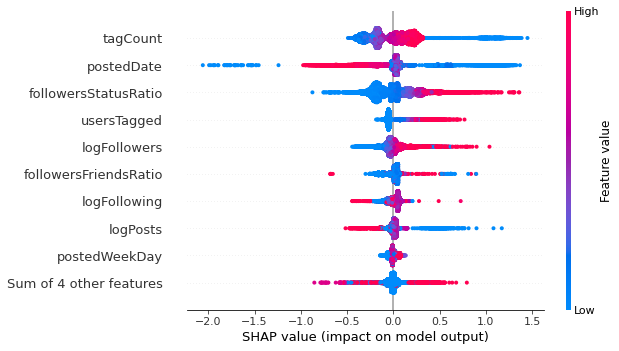

In [18]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

## Ensemble of models
The following code is highly inspired by this blog post: https://machinelearningmastery.com/super-learner-ensemble-in-python/.

In the following cells, we will explore how to make an ensemble of models. We have in previous classes talked about how the Netflix challenge was won by using predictions from multiple models, so this can indeed be a very powerful approach. Now we will test this on our Instagram data set: we use the same features and again predict the log likes.

In [19]:
# example of a super learner model for regression
from math import sqrt
from numpy import hstack
from numpy import vstack
from numpy import asarray
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

We will create a list of base models to use in our ensemble model. Here, we use linear regression, a multilayer perceptron, KNN, a decision tree and XGBoost with two types of configurations. If you want, you can easily add other models. But remember to consider the training time, predictive performance and the diversity of the models.

In [20]:
# create a list of base-models
def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(MLPRegressor())
    models.append(KNeighborsRegressor())
    models.append(DecisionTreeRegressor())
    models.append(XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.1))
    models.append(XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.3))
    return models

To make an ensemble of models, we will use cross-validation and the concepts of stacked generalization to avoid overfitting the training data. The idea is summarized in the figure below, but we also describe the steps in the text.

In step 1-3, we will do regular k-fold cross-validation on the training set (step 1) and then fit the base models for each data split (step 2). For each of these models, we make predictions on the fold of training data we do not use for fitting the model to obtain *out-of-fold predictions* (step 3). These out-of-fold predictions can now be used to train the *meta-model* without overfitting to the predictions of base models. This is the concept of stacked generalization since we are stacking models but only use "unseen" data every time we fit a model.

In step 4, we fit the meta-model on the out-of-fold predictions.

In step 5, we are now ready to use the model, i.e. make predictions and evaluate. But as you see in the figure,  we also have a step 0, where we fit each base model to the entire training data. We only need the out-of-fold predictions to fit the meta-model, but when we have done that we can instead utilize all the training data to fit the base models for best performance.

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/10/Diagram-Showing-the-Data-Flow-of-the-Super-Learner-Algorithm.png" alt="Pipeline" style="width: 700px;"/>
(Source: Van der Laan, Mark J., Eric C. Polley, and Alan E. Hubbard. "Super learner." Statistical applications in genetics and molecular biology 6.1 (2007).)


In the following, we will make the necessary functions to make and use the meta-model.


First, we make a function to collect the out-of-fold predictions from the k-fold cross-validation.

In [21]:
# collect out-of-fold predictions from k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
    meta_X, meta_y = list(), list()
    # define split of data
    n_splits = 10
    kfold = KFold(n_splits=n_splits, shuffle=True)
    # enumerate splits
    for train_ix, test_ix in tqdm(kfold.split(X), total=n_splits):
        fold_yhats = list()
        # get data
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        meta_y.extend(test_y)
        # fit and make predictions with each sub-model
        for model in models:
            model.fit(train_X, train_y)
            yhat = model.predict(test_X)
            # store columns
            fold_yhats.append(yhat.reshape(len(yhat),1))
        # store fold yhats as columns
        meta_X.append(hstack(fold_yhats))
    return vstack(meta_X), asarray(meta_y)

We also make a wrapper to fit the base models.

In [22]:
# fit all base models on the training dataset
def fit_base_models(X, y, models):
    for model in models:
        model.fit(X, y)

After we have collected the predictions from the base model, we will fit another model (linear regression) to predict the final predictions. We will use the following model to do so.

In [23]:
# fit a meta model
def fit_meta_model(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

We will also define a function to evaluate each of the base models. When we train each model for our ensemble model, it would be unwise not to check the performance of each model. It might be that one of them can be excluded due to very bad performance or that it is very slow to fit. Whether to include or exclude a model is highly dependent on the data and the use case.

In [24]:
# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
    for model in models:
        yhat = model.predict(X)
        mse = mean_squared_error(y, yhat)
        mae = mean_absolute_error(y, yhat)
        print('%s:\n\tRMSE %.4f, MAE %.4f' % (model.__class__.__name__, sqrt(mse), mae))

Finally, we will make a function to make the predictions with the stacked model. We should stack the predictions for each of the base models to create a new list of inputs to the meta-model. So that is, given our fitted base models, to make predictions with each base model, stack predictions together and then use these predictions as inputs for the meta-model to make the final prediction.

In [25]:
# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
    meta_X = list()
    for model in models:
        yhat = model.predict(X)
        meta_X.append(yhat.reshape(len(yhat), 1))
    meta_X = hstack(meta_X)
    # predict
    return meta_model.predict(meta_X)


Now, we are ready to use all the functions and make our ensemble of models.

In [26]:
# We do the "lazy" data split with only a training and test split. 
# If you should do this correct, you should also make a validation set,
X, X_val, y, y_val=train_test_split(dataset[features].values, dataset['logLikes'].values,
                                    shuffle=True, random_state=42)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)

# Get models
models = get_models()

print("\nDo cross validation to get out-of-fold predictions..")
# Get out of fold predictions, i.e. make predictions with the base models.
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta data set ', meta_X.shape, meta_y.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

Train (39004, 13) (39004,) Test (13002, 13) (13002,)

Do cross validation to get out-of-fold predictions..


100%|██████████| 10/10 [01:05<00:00,  6.55s/it]

Meta data set  (39004, 6) (39004,)


In [27]:
# Fit base models
print("Fitting the base models..")
fit_base_models(X, y, models)

# Fit the meta model, i.e. make the final prediction given the predictions of the base models.
print("Fitting the meta model..")
meta_model = fit_meta_model(meta_X, meta_y)

Fitting the base models..
Fitting the meta model..


Evaluate the models on the test set:

In [28]:
# Evaluate base models (to check the individual performance)
evaluate_models(X_val, y_val, models)

# Evaluate meta model
yhat = super_learner_predictions(X_val, models, meta_model)

rmse = sqrt(mean_squared_error(y_val, yhat))
mae = mean_absolute_error(y_val, yhat)
print("\n")
print('%s:\n\tRMSE %.4f, MAE %.4f' % ("Super Learner (meta model)", rmse, mae))

LinearRegression:
	RMSE 1.2855, MAE 1.0651
MLPRegressor:
	RMSE 2.2330, MAE 1.2551
KNeighborsRegressor:
	RMSE 1.3618, MAE 1.1075
DecisionTreeRegressor:
	RMSE 1.7223, MAE 1.3537
XGBRegressor:
	RMSE 1.2165, MAE 1.0026
XGBRegressor:
	RMSE 1.2330, MAE 1.0098


Super Learner (meta model):
	RMSE 1.2142, MAE 0.9997


We see two things: 1) The meta-model is slightly better than the best base model, and 2) XGBoost is just a very good algorithm (at least for this data set). 

Going back to the goal of predicting the number of likes, we have now found that the ensemble of models is best but maybe not worth the extra effort compared to just applying XGBoost. That said, you should keep in mind that we are predicting the log likes, so the errors will be more significant for the absolute number of likes.